In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

631600
[317358, 314242]


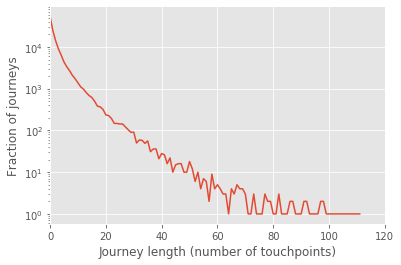

In [3]:
# Data exploration

def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts

hist_all = journey_lenght_histogram(df4)

plt.plot(range(len(hist_all)), hist_all, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

In [4]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

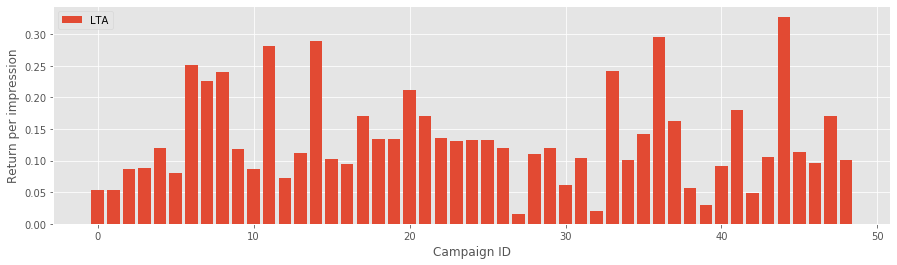

In [118]:
# Visualization of the attribution scores

campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [6]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['uid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

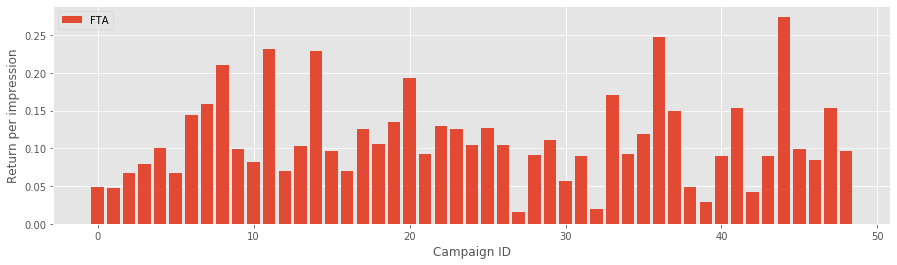

In [117]:
# Visualization of the attribution scores

campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Linear

In [164]:
id_count = df6.groupby(['uid'])['campaign'].count()

In [165]:
df_id_count = pd.DataFrame(id_count.reset_index())

In [166]:
df_id_count.columns

Index(['uid', 'campaign'], dtype='object')

In [167]:
df_id_count = df_id_count.rename(columns={"campaign":"campaign_count"})

In [168]:
df_conv_user = df6[df6['conversion'] ==1]



In [169]:
df_conv_user = df_conv_user.sort_values('uid')



In [170]:
df_conv_user

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
399253,474703,656,27777499,1,718877,26044415,0,1,1,3,...,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
417527,45703,656,27777499,1,718877,26044415,0,1,0,3,...,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
209599,554012,656,27777499,1,718877,26044415,0,1,2,3,...,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
127262,2143779,999,5061834,1,4103933,14996161,0,1,2,4,...,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27331,1617199,999,5061834,1,4103933,14996161,0,1,0,4,...,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590007,497632,32458202,2576437,1,625696,26332147,0,1,16,17,...,32440044,1973606,3698652,29196072,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
250411,65934,32458202,2576437,1,625696,26332147,0,1,14,17,...,32440044,1973606,3698652,9068204,9491354,32458202_26332147,0.024683,0.015056,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6530,24327,32458202,2576437,1,625696,26332147,0,1,12,17,...,32440044,1973606,23932668,26597096,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
413621,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,...,11409686,1973606,9312274,20754144,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [171]:
df_merge = df_conv_user.merge(df_id_count, on = ['uid'], how = 'left')



In [172]:
df_merge

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count
0,474703,656,27777499,1,718877,26044415,0,1,1,3,...,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,45703,656,27777499,1,718877,26044415,0,1,0,3,...,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2,554012,656,27777499,1,718877,26044415,0,1,2,3,...,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,2143779,999,5061834,1,4103933,14996161,0,1,2,4,...,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,1617199,999,5061834,1,4103933,14996161,0,1,0,4,...,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314237,497632,32458202,2576437,1,625696,26332147,0,1,16,17,...,1973606,3698652,29196072,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
314238,65934,32458202,2576437,1,625696,26332147,0,1,14,17,...,1973606,3698652,9068204,9491354,32458202_26332147,0.024683,0.015056,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
314239,24327,32458202,2576437,1,625696,26332147,0,1,12,17,...,1973606,23932668,26597096,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
314240,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,...,1973606,9312274,20754144,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [173]:
camp_prob = []



In [174]:
for index , row in df_merge.iterrows():
  camp_prob.append(1/row['campaign_count'])
df_merge['campaign_probability'] =   camp_prob

In [175]:
df_merge

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,campaign_probability
0,474703,656,27777499,1,718877,26044415,0,1,1,3,...,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
1,45703,656,27777499,1,718877,26044415,0,1,0,3,...,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
2,554012,656,27777499,1,718877,26044415,0,1,2,3,...,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
3,2143779,999,5061834,1,4103933,14996161,0,1,2,4,...,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
4,1617199,999,5061834,1,4103933,14996161,0,1,0,4,...,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314237,497632,32458202,2576437,1,625696,26332147,0,1,16,17,...,3698652,29196072,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
314238,65934,32458202,2576437,1,625696,26332147,0,1,14,17,...,3698652,9068204,9491354,32458202_26332147,0.024683,0.015056,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
314239,24327,32458202,2576437,1,625696,26332147,0,1,12,17,...,23932668,26597096,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
314240,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,...,9312274,20754144,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.500000


In [176]:
linear = df_merge.groupby('campaign')['campaign_probability'].sum()

In [177]:
linear



campaign
73325        42.458333
73328       128.196769
83677        67.793407
336258       11.000000
442617       34.119048
               ...    
32385772     17.000000
32398755     87.980082
32398758     59.822552
32405311     26.500000
32452108     34.881016
Name: campaign_probability, Length: 400, dtype: float64

In [178]:
df_linear = pd.DataFrame(linear)

In [179]:
df_linear = df_linear.reset_index()

In [180]:
df_linear

,campaign,campaign_probability
0,73325,42.458333
1,73328,128.196769
2,83677,67.793407
3,336258,11.000000
4,442617,34.119048
...,...,...
395,32385772,17.000000
396,32398755,87.980082
397,32398758,59.822552
398,32405311,26.500000


In [181]:
df6['campaign'].value_counts()

15398570    31289
15184511    31192
32368244    28979
17686799    16982
31772643    16430
            ...  
25391297       16
16184514        8
21443097        7
13442456        3
20443097        2
Name: campaign, Length: 400, dtype: int64

In [182]:
camp_count=df6['campaign'].value_counts()

In [183]:
camp_count

15398570    31289
15184511    31192
32368244    28979
17686799    16982
31772643    16430
            ...  
25391297       16
16184514        8
21443097        7
13442456        3
20443097        2
Name: campaign, Length: 400, dtype: int64

In [184]:
new_df = pd.DataFrame(camp_count.reset_index())

In [185]:
new_df

,index,campaign
0,15398570,31289
1,15184511,31192
2,32368244,28979
3,17686799,16982
4,31772643,16430
...,...,...
395,25391297,16
396,16184514,8
397,21443097,7
398,13442456,3


In [186]:
new_df.rename(columns={'index':'campaign',
                          'campaign':'campaign_count',}, inplace=True)

In [187]:
new_df.sort_values('campaign')

,campaign,campaign_count
216,73325,433
143,73328,805
127,83677,961
375,336258,62
249,442617,319
...,...,...
299,32385772,212
61,32398755,2304
182,32398758,550
328,32405311,142


In [188]:
df_linear

,campaign,campaign_probability
0,73325,42.458333
1,73328,128.196769
2,83677,67.793407
3,336258,11.000000
4,442617,34.119048
...,...,...
395,32385772,17.000000
396,32398755,87.980082
397,32398758,59.822552
398,32405311,26.500000


In [189]:
camp_df = df_linear.merge(new_df, on = ['campaign'], how = 'left')

In [190]:
camp_df.shape

(400, 3)

In [191]:
camp_wt = []

In [192]:
camp_df['campaign_wt']  = camp_df['campaign_probability'] /camp_df['campaign_count'] 

In [193]:
camp_df.head()

,campaign,campaign_probability,campaign_count,campaign_wt
0,73325,42.458333,433,0.098056
1,73328,128.196769,805,0.159251
2,83677,67.793407,961,0.070545
3,336258,11.000000,62,0.177419
4,442617,34.119048,319,0.106956


In [194]:
lin = camp_df['campaign_wt']

In [195]:
lin = lin.to_numpy()

In [196]:
type(lin)

numpy.ndarray

In [197]:
lin_plot_df = camp_df[1:50]

In [198]:
lin_plot_df

,campaign,campaign_probability,campaign_count,campaign_wt
1,73328,128.196769,805,0.159251
2,83677,67.793407,961,0.070545
3,336258,11.000000,62,0.177419
4,442617,34.119048,319,0.106956
5,497590,97.730769,1355,0.072126
6,604244,105.166667,968,0.108643
7,690012,56.306714,588,0.095760
8,716288,70.560714,1327,0.053173
9,804100,209.851302,1709,0.122792
10,884761,94.703093,1823,0.051949


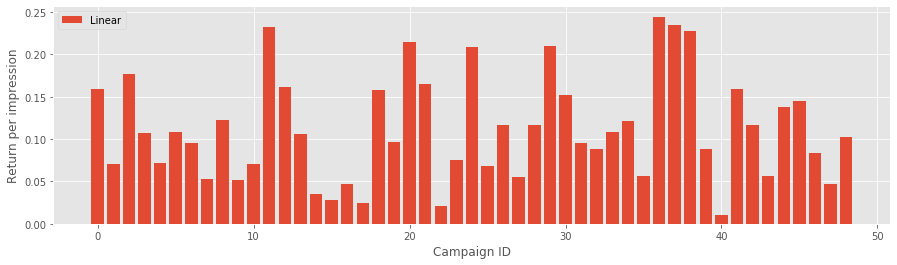

In [199]:
# Visualization of the attribution scores

campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(lin_plot_df['campaign'])), lin_plot_df['campaign_wt'], label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# U-Shape

In [42]:
df6

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
511642,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,5824237,138937,1795451,29196072,15351056,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
495976,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130288,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,5824237,1973606,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3125,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,11409684,26597096,4480345,29196072,29196072,25357769_-1,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
134012,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,32440044,1973606,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260122,2671166,477683,32368244,1,3084323,18913526,0,1,1,4,...,11409684,26597099,16407721,29196072,29520626,477683_18913526,9.999876e-01,0.047933,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
463159,2671171,21464622,14121532,1,4738990,15614650,0,1,1,3,...,11409686,28928366,25063773,29196072,29520626,21464622_15614650,9.999895e-01,0.046214,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
102249,2671172,32118557,15398570,1,2973215,8167674,1,1,2,4,...,32440044,29196072,14573904,29196072,9491351,32118557_8167674,9.999899e-01,0.008627,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
416285,2671175,12769977,6686704,0,-1,-1,0,1,-1,-1,...,32440044,1973606,11871047,3225256,29196072,12769977_-1,9.999910e-01,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
time_min = df_conv_user.groupby(['uid'])['campaign','timestamp_norm'].min()
time_max = df_conv_user.groupby(['uid'])['campaign','timestamp_norm'].max()

In [44]:
df_min_time = pd.DataFrame(time_min)
df_max_time = pd.DataFrame(time_max)

In [45]:
df_min_time = df_min_time.reset_index()
df_max_time = df_max_time.reset_index()

In [46]:
df_min_time
df_min_time = df_min_time.rename(columns={"timestamp_norm":"min_timestamp"})

In [47]:
df_max_time.head()
df_max_time = df_max_time.rename(columns={"timestamp_norm":"max_timestamp"})

In [48]:
df_merge_time_max = pd.merge(df_merge,df_max_time,  how = 'inner', on =(['uid','campaign']),)
df_merge_time_min = pd.merge(df_merge_time_max,df_min_time,  how = 'inner', on =(['uid','campaign']),)

In [49]:
df_u_shape = df_merge_time_min

In [50]:
df_u_shape = df_u_shape.drop(columns=['campaign_probability'])

In [51]:
df_u_shape['u_prob'] = np.where(df_u_shape['timestamp_norm']==df_u_shape['max_timestamp'], 
                                           '0.4', 
                                           np.where(df_u_shape['timestamp_norm']==df_u_shape['min_timestamp'], 
                                           '0.4', 0.2*(1/(df_u_shape['campaign_count']-2))))


In [52]:
df_u_shape.loc[df_u_shape.campaign_count == 1, 'u_prob'] = 1
df_u_shape.loc[df_u_shape.campaign_count == 2, 'u_prob'] = 0.5

In [53]:
df_u_shape

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,max_timestamp,min_timestamp,u_prob
0,474703,656,27777499,1,718877,26044415,0,1,1,3,...,21091111,656_26044415,0.177712,0.165510,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.2
1,45703,656,27777499,1,718877,26044415,0,1,0,3,...,21091108,656_26044415,0.017110,0.078264,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.4
2,554012,656,27777499,1,718877,26044415,0,1,2,3,...,29520629,656_26044415,0.207402,0.030598,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.4
3,2143779,999,5061834,1,4103933,14996161,0,1,2,4,...,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.4
4,1617199,999,5061834,1,4103933,14996161,0,1,0,4,...,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304716,497632,32458202,2576437,1,625696,26332147,0,1,16,17,...,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.4
304717,65934,32458202,2576437,1,625696,26332147,0,1,14,17,...,9491354,32458202_26332147,0.024683,0.015056,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.06666666666666667
304718,24327,32458202,2576437,1,625696,26332147,0,1,12,17,...,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.4
304719,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,...,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.403773,0.403742,0.5


In [54]:
df_u_shape['campaign'].value_counts()

32368244    24695
15184511    24022
15398570    18596
29427842     9046
31772643     8190
            ...  
23310435        4
27644431        4
13442456        3
20443097        2
18496278        2
Name: campaign, Length: 400, dtype: int64

In [55]:
u_shape_camp_count=df_u_shape['campaign'].value_counts()

In [56]:
u_shape_camp_count = pd.DataFrame(u_shape_camp_count.reset_index())

In [57]:
u_shape_camp_count

,index,campaign
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [58]:
u_shape_camp_count.rename(columns={'index':'campaign',
                          'campaign':'campaign_count',}, inplace=True)

In [59]:
u_shape_camp_count

,campaign,campaign_count
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [60]:
df_u_shape.dtypes

timestamp                      object
uid                            object
campaign                       object
conversion                     object
conversion_timestamp           object
conversion_id                  object
attribution                    object
click                          object
click_pos                      object
click_nb                       object
cost                          float64
cpo                           float64
time_since_last_click          object
cat1                           object
cat2                           object
cat3                           object
cat4                           object
cat5                           object
cat6                           object
cat7                           object
cat8                           object
cat9                           object
jid                            object
timestamp_norm                float64
time_since_last_click_norm    float64
cats                           object
campaigns   

In [61]:
df_u_shape = df_u_shape.astype({"u_prob": float}) 

In [62]:
U_prob_sum = df_u_shape.groupby('campaign')['u_prob'].sum()

In [63]:
U_prob_sum

campaign
73325        41.000000
73328       129.263054
83677        68.636364
336258       11.000000
442617       34.600000
               ...    
32385772     17.000000
32398755     90.223816
32398758     58.857143
32405311     26.000000
32452108     34.756190
Name: u_prob, Length: 400, dtype: float64

In [64]:
U_prob_sum = pd.DataFrame(U_prob_sum)

In [65]:
U_prob_sum = U_prob_sum.reset_index()

In [66]:
U_prob_sum

,campaign,u_prob
0,73325,41.000000
1,73328,129.263054
2,83677,68.636364
3,336258,11.000000
4,442617,34.600000
...,...,...
395,32385772,17.000000
396,32398755,90.223816
397,32398758,58.857143
398,32405311,26.000000


In [67]:
u_shape_camp_count

,campaign,campaign_count
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [68]:
u_shape_final = U_prob_sum.merge(u_shape_camp_count, on = ['campaign'], how = 'left')

In [69]:
u_shape_final

,campaign,u_prob,campaign_count
0,73325,41.000000,173
1,73328,129.263054,411
2,83677,68.636364,224
3,336258,11.000000,35
4,442617,34.600000,115
...,...,...,...
395,32385772,17.000000,58
396,32398755,90.223816,457
397,32398758,58.857143,296
398,32405311,26.000000,96


In [70]:
u_shape_final['campaign_wt']  = u_shape_final['u_prob'] /u_shape_final['campaign_count']

In [71]:
u_shape_final

,campaign,u_prob,campaign_count,campaign_wt
0,73325,41.000000,173,0.236994
1,73328,129.263054,411,0.314509
2,83677,68.636364,224,0.306412
3,336258,11.000000,35,0.314286
4,442617,34.600000,115,0.300870
...,...,...,...,...
395,32385772,17.000000,58,0.293103
396,32398755,90.223816,457,0.197426
397,32398758,58.857143,296,0.198842
398,32405311,26.000000,96,0.270833


In [72]:
Ushape = u_shape_final['campaign_wt']

In [200]:
plt_ushape_df = u_shape_final[1:50]

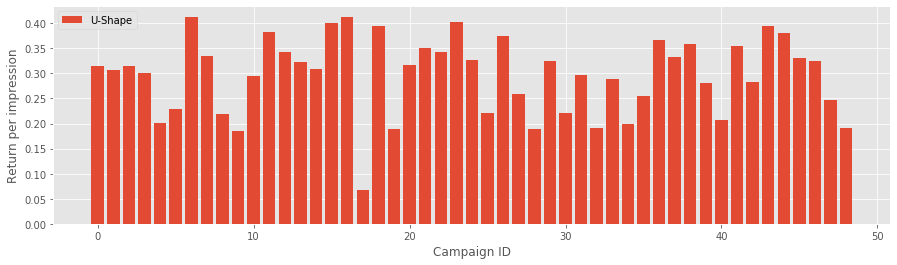

In [201]:
campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(plt_ushape_df['campaign'])), plt_ushape_df['campaign_wt'], label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Time Decay

In [74]:
df_time_decay = df_merge_time_min

In [75]:
df_time_decay = df_time_decay.drop(columns=['campaign_probability'])

In [76]:
df_time_decay['time_decay_prob'] = np.where(df_time_decay['timestamp_norm']==df_time_decay['max_timestamp'], 
                                           0.6,
                                            np.where(df_time_decay['campaign_count'] == 2 ,
                                                     0.4,
                                                     np.random.uniform(0, 0.4, len(df_time_decay))))

In [77]:
df_time_decay.shape[0]

304721

In [78]:
df_time_decay

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,max_timestamp,min_timestamp,time_decay_prob
0,474703,656,27777499,1,718877,26044415,0,1,1,3,...,21091111,656_26044415,0.177712,0.165510,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.155084
1,45703,656,27777499,1,718877,26044415,0,1,0,3,...,21091108,656_26044415,0.017110,0.078264,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.038893
2,554012,656,27777499,1,718877,26044415,0,1,2,3,...,29520629,656_26044415,0.207402,0.030598,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.600000
3,2143779,999,5061834,1,4103933,14996161,0,1,2,4,...,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.600000
4,1617199,999,5061834,1,4103933,14996161,0,1,0,4,...,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.143270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304716,497632,32458202,2576437,1,625696,26332147,0,1,16,17,...,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.600000
304717,65934,32458202,2576437,1,625696,26332147,0,1,14,17,...,9491354,32458202_26332147,0.024683,0.015056,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.343102
304718,24327,32458202,2576437,1,625696,26332147,0,1,12,17,...,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.186295,0.009107,0.177877
304719,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,...,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.403773,0.403742,0.400000


In [79]:
df_time_decay['campaign'].value_counts()

32368244    24695
15184511    24022
15398570    18596
29427842     9046
31772643     8190
            ...  
23310435        4
27644431        4
13442456        3
20443097        2
18496278        2
Name: campaign, Length: 400, dtype: int64

In [80]:
time_decay_count=df_time_decay['campaign'].value_counts()

In [81]:
time_decay_count = pd.DataFrame(time_decay_count.reset_index())

In [82]:
time_decay_count

,index,campaign
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [83]:
time_decay_count.rename(columns={'index':'campaign',
                          'campaign':'campaign_count',}, inplace=True)

In [84]:
time_decay_count

,campaign,campaign_count
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [85]:
time_decay_prob_sum = df_time_decay.groupby('campaign')['time_decay_prob'].sum()

In [86]:
time_decay_prob_sum

campaign
73325        55.372536
73328       149.377283
83677        79.232022
336258       11.452892
442617       40.931504
               ...    
32385772     20.319692
32398755    139.375407
32398758     85.198512
32405311     31.657545
32452108     42.797180
Name: time_decay_prob, Length: 400, dtype: float64

In [87]:
time_decay_prob_sum = pd.DataFrame(time_decay_prob_sum)

In [88]:
time_decay_prob_sum = time_decay_prob_sum.reset_index()

In [89]:
time_decay_prob_sum

,campaign,time_decay_prob
0,73325,55.372536
1,73328,149.377283
2,83677,79.232022
3,336258,11.452892
4,442617,40.931504
...,...,...
395,32385772,20.319692
396,32398755,139.375407
397,32398758,85.198512
398,32405311,31.657545


In [90]:
time_decay_count

,campaign,campaign_count
0,32368244,24695
1,15184511,24022
2,15398570,18596
3,29427842,9046
4,31772643,8190
...,...,...
395,23310435,4
396,27644431,4
397,13442456,3
398,20443097,2


In [91]:
time_decay_final = time_decay_prob_sum.merge(time_decay_count, on = ['campaign'], how = 'left')

In [92]:
time_decay_final

,campaign,time_decay_prob,campaign_count
0,73325,55.372536,173
1,73328,149.377283,411
2,83677,79.232022,224
3,336258,11.452892,35
4,442617,40.931504,115
...,...,...,...
395,32385772,20.319692,58
396,32398755,139.375407,457
397,32398758,85.198512,296
398,32405311,31.657545,96


In [93]:
time_decay_final['campaign_wt']  = time_decay_final['time_decay_prob'] /time_decay_final['campaign_count']

In [94]:
time_decay_final

,campaign,time_decay_prob,campaign_count,campaign_wt
0,73325,55.372536,173,0.320072
1,73328,149.377283,411,0.363448
2,83677,79.232022,224,0.353714
3,336258,11.452892,35,0.327225
4,442617,40.931504,115,0.355926
...,...,...,...,...
395,32385772,20.319692,58,0.350340
396,32398755,139.375407,457,0.304979
397,32398758,85.198512,296,0.287833
398,32405311,31.657545,96,0.329766


In [202]:
plt_tdcay_df = time_decay_final[1:50]

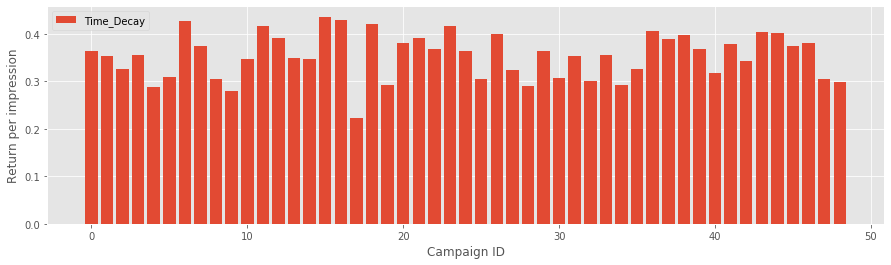

In [203]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(plt_tdcay_df['campaign'])), plt_tdcay_df['campaign_wt'], label='Time_Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [96]:
tdecay = time_decay_final['campaign_wt']

In [97]:
tdecay.shape

(400,)

In [98]:
type(tdecay)

pandas.core.series.Series

In [99]:
tdecay = tdecay.to_numpy()

In [100]:
type(tdecay)

numpy.ndarray

# Simulation

In [261]:
def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [262]:
#simulate_budget_roi(df6, 10000, lta**0.1)

In [263]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [355]:
lst = []

In [357]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta,tdecay,fta,lin,Ushape]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
#         df['j'].append(j) 
        lst.append(reward)
#         df['reward'].append(reward)
#         df['reward'] = reward
#         print('{} {} : {}'.format(p, j, reward))

In [358]:
print(lst)

[995, 856, 929, 863, 855, 928, 853, 859, 869, 852, 561, 850, 278, 844, 845, 253, 836, 259, 440, 808, 308, 803, 313, 218, 707, 362, 727, 371, 304, 532, 410, 559, 427, 308, 328, 468, 497, 470, 337, 228]


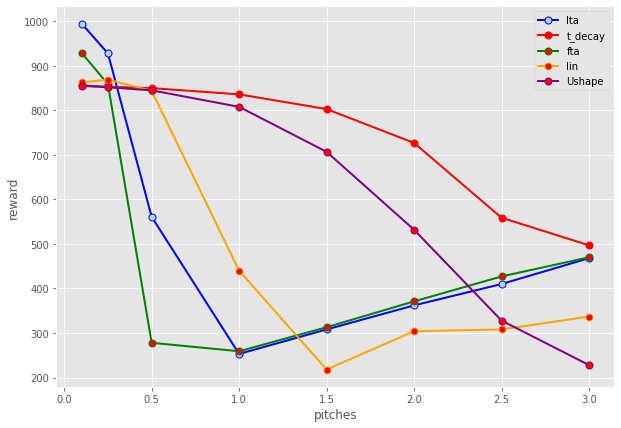

In [375]:

fig = plt.figure(figsize=(10, 7))
plt.plot([.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [995,928,561,253,308,362,410,468], label = 'lta', marker='o', markerfacecolor='lightblue', markersize=7, color='blue', linewidth=2)
plt.plot([.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [856,853,850,836,803,727,559,497], label = 't_decay', marker='o', markerfacecolor='red', markersize=7, color='red', linewidth=2)
plt.plot([.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [929,859,278,259,313,371,427,470], label = 'fta', marker='o', markerfacecolor='red', markersize=7, color='green', linewidth=2)
plt.plot([.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [863,869,844,440,218,304,308,337], label = 'lin', marker='o', markerfacecolor='red', markersize=7, color='orange', linewidth=2)
plt.plot([.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [855,852,845,808,707,532,328,228], label = 'Ushape', marker='o', markerfacecolor='red', markersize=7, color='purple', linewidth=2)
plt.xlabel('pitches')
plt.ylabel('reward')
plt.legend()

# Dash

In [205]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

In [122]:
app = dash.Dash()

In [131]:
app = dash.Dash()
app.layout = html.Div([
    html.Div([
        html.Div([
            html.H3('LTA'),
            dcc.Graph(id='g1', figure={'data': [                
                {'x': len(lta[campaign_idx]) , 'y': lta[campaign_idx], 'type': 'bar', 'name': 'LTA'},
            ]})
        ], className="six columns"),
        
        html.Div([
            html.H3('tdecay'),
            dcc.Graph(id='g2', figure={'data': [                
                {'x': len(time_decay_final['campaign']) , 'y': time_decay_final['campaign_wt'], 'type': 'bar', 'name': 'LTA'},
            ]})
        ], className="six columns"),
        
        html.Div([
            html.H3('FTA'),
            dcc.Graph(id='g3', figure={'data': [
                {'x': len(fta[campaign_idx]) , 'y': fta[campaign_idx], 'type': 'bar', 'name': 'FTA'}
            ]})
        ], className="six columns"),
    ], className="row")
])

In [210]:
app.layout = html.Div(children=[
    html.H1(
        children='Attribution Models',
        style={
            'textAlign': 'center'
            
        }
    ),
    
    html.Div([
    html.Label('Dropdown'),
    dcc.Dropdown(
        options=[
            {'label': 'Last Touch Attribution', 'value': 'LTA'},
            {'label': u'First Touch Attribution', 'value': 'FTA'},
            {'label': 'Linear Attribution', 'value': 'LA'},
            {'label': 'U-Shape attribution', 'value': 'USA'},
            {'label': 'Time Decay Attribution', 'value': 'T-Decay'}
        ],
        value='LTA'
    ),

]),
    
    html.Div([
            html.H3('FTA'),
            dcc.Graph(id='g1', figure={'data': [
                {'x': len(fta[campaign_idx]) , 'y': fta[campaign_idx], 'type': 'bar', 'name': 'FTA'}
            ]})
        ], className="six columns"),
    
    html.Div([
            html.H3('Linear'),
            dcc.Graph(id='g2', figure={'data': [
                {'x': len(lin_plot_df[campaign]) , 'y': lin_plot_df[campaign_wt], 'type': 'bar', 'name': 'Linear'}
            ]})
        ], className="six columns"),
    
    html.Div([
            html.H3('Ushape'),
            dcc.Graph(id='g3', figure={'data': [
                {'x': len(plt_ushape_df[campaign]) , 'y': plt_ushape_df[campaign_wt], 'type': 'bar', 'name': 'Ushape'}
            ]})
        ], className="six columns"),
    
    html.Div([
            html.H3('Time Decay'),
            dcc.Graph(id='g4', figure={'data': [
                {'x': len(plt_tdcay_df[campaign]) , 'y': plt_tdcay_df[campaign_wt], 'type': 'bar', 'name': 'Time Decay'}
            ]})
        ], className="six columns"),
    
    
    
    

    dcc.Graph(
        id='example-graph',
        figure={
            'data': [
                {'x': [.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'y': [995,928,561,253,308,362,410,468], 'type': 'line', 'name': 'lta'},
                {'x': [.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'y': [856,853,850,836,803,727,559,497], 'type': 'line', 'name': 'tdecay'},
                {'x': [.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'y': [929,859,278,259,313,371,427,470], 'type': 'line', 'name': 'fta'},
                {'x': [.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'y': [863,869,844,440,218,304,308,337], 'type': 'line', 'name': 'lin'},
                {'x': [.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'y': [855,852,845,808,707,532,328,228], 'type': 'line', 'name': 'ushape'}
            ],
            'layout': {
                'title': 'Revenue Simulation'
            }
        }
    )
])

In [211]:
if __name__ == '__main__':
    app.run_server(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
